In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import datetime
import scipy
from scipy.stats import binned_statistic_2d
%matplotlib inline

In [3]:
%%time
#Читаем данные за май 2016
dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
#dateparser = lambda x: pd.to_datetime(x).round('d')
cols_to_use = ['tpep_pickup_datetime', 
               'tpep_dropoff_datetime',
               'passenger_count',
               'trip_distance',
               'pickup_longitude', 
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude']
data = pd.read_csv('TaxiData/yellow_tripdata_2016-05.csv', delimiter=',',
                   usecols=cols_to_use, 
                   parse_dates=dates)
                   #, date_parser  = dateparser)

Wall time: 28.5 s


In [4]:
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,-73.983986,40.730099
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,-73.975700,40.765469
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,-73.980995,40.744633
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,-74.002258,40.733002
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,-73.997498,40.737564


In [5]:
#Проверяем пустые значения
print data.isnull().values.any()

#Задаем границы 
long_min = -74.25559
long_max = -73.70001 
lat_min = 40.49612
lat_max = 40.91553

False


In [6]:
#Фильтруем данные по границам, длительности, кол-ву пассажиров, длине поездки.

zero_delta = datetime.timedelta(seconds=0)

f_data = data[((data.tpep_dropoff_datetime - data.tpep_pickup_datetime) > zero_delta) 
                     & (data.passenger_count > 0) 
                     & (data.trip_distance > 0)
                     & (long_min <= data.pickup_longitude)
                     & (data.pickup_longitude <= long_max)
                     & (lat_min <= data.pickup_latitude)
                     & (data.pickup_latitude <= lat_max)
             ]

In [7]:
f_data.shape#11626521

(11626521, 8)

In [8]:
#Читаем регионы
regions = pd.read_csv('TaxiData/regions.csv', delimiter=';')


In [9]:
%%time
#Групируем данные по кждому часу из месяца
grp = f_data.groupby(f_data.tpep_pickup_datetime.dt.round('h'))


Wall time: 338 ms


In [10]:
#Получение количества поездок в каждой области
def getGroupStat(group):
    return binned_statistic_2d(group.pickup_longitude, 
                                                       group.pickup_latitude, 
                                                       None,
                                                       statistic='count',
                                                       bins=50, 
                                                       range=[[long_min, long_max], [lat_min, lat_max]])
#Получение аггрегирванных данных для каждой группы
def aggregateGroup(group):
    key = group[0:1].tpep_pickup_datetime.dt.floor('h').values[0]
    stat, x_edge , y_edge, binnumber = getGroupStat(group)
    row = [key]
    row.extend(stat.flatten())
    #print row
    a_data.loc[a_data.shape[0]] = row
    #print stat.flatten().shape
    return row
    

In [11]:
%%time
#Создание фрейма с резульатом
a_data = pd.DataFrame(columns=['time'] + range(1,2501))

Wall time: 63 ms


In [12]:
%%time
#Делаем рассчеты
grp.apply(lambda g: aggregateGroup(g))

#Удаляем первую строку (соглсано документации:)
#Warning In the current implementation apply calls func twice on the first group to decide whether it can take a fast or slow code path. This can lead to unexpected behavior if func has side-effects, as they will take effect twice for the first group.
a_data.drop(0,inplace=True)

Wall time: 1min 7s


In [13]:
a_data

,time,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
1,2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-05-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-05-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-05-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016-05-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2016-05-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2016-05-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2016-05-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2016-05-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#Границы Empire State Building
esb_lat = 40.748351
esb_long = -73.985621

In [15]:
#Находим регион Empire State Building
regions[(regions.west <= esb_long) & (esb_long <= regions.east) & (regions.south <= esb_lat) & (esb_lat <= regions.north)]

,region,west,east,south,north
1230,1231,-73.988912,-73.9778,40.747766,40.756154


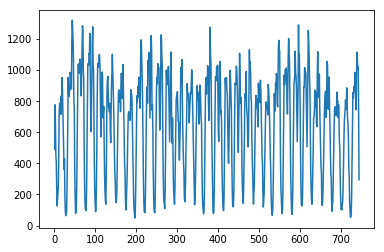

489489.0

In [16]:
#Выводим для него график
plt.plot(a_data[1231])
plt.show()
a_data[1231].sum()

In [17]:
#Коневертируем фрейм в данные типа бул (получаем ячейки с информацией была поездка или нет)
counts_frame = a_data.drop(['time'], axis=1).astype(bool)

In [18]:
#Берем общее количество ячеек и вычитаем те что равны true
counts_frame.shape[0] * counts_frame.shape[1] - counts_frame.sum().sum()

1720475L

In [21]:
744 * 2500  - counts_frame.sum().sum()

1717975L

In [20]:
s.dropna().shape

NameError: name 's' is not defined

In [31]:
745 * 2500

1862500